Copyright (c) 2024, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause 

In this notebook, we go over the Grover's algorithm to show how to use cuTensorNet `NetworkState` APIs to execute a qiskit.circuit instance.

The Notebook consists of the parts as follows:
1. Grover's algorithm explanation.
2. Creating the Grover's circuit using Qiskit.
3. Steps to run the Grover's circuit using cuTensorNet.
4. Steps to run the Grover's circuit on Qiskit to show results are equal.  

## Grover's Algorithm Overview

Imagine you have a large list of $N$ items, and among them, there is one item with a unique property that you need to find. Grover's algorithm is designed to efficiently locate this item and consists of three main components:

1. State preparation: This step involves preparing a quantum state that represents the entire search space. In our example, this means including all the items in the list.
2. Oracle function: The oracle function is responsible for identifying the correct item(s) by marking them. It essentially flags the item with the unique property.
3. Diffusion operator: The diffusion operator amplifies the probability of the marked item(s) so that they stand out. This amplification ensures that the correct item(s) can be measured and identified at the end of the algorithm.
    
To get the result with probability close to 1 we repeat steps 2 and 3 $O(\sqrt{N})$. By combining these three parts, Grover's algorithm efficiently narrows down the search to locate the item with the unique property. 

### Example: 
Consider we have $N = 16$ items in a list which is realized with 4 qubits. Now, we are looking for item $|1111\rangle$ which is called winner.

In [1]:
import matplotlib.pyplot as plt

import qiskit
from qiskit.circuit.library import ZGate

from cuquantum.cutensornet.experimental import NetworkState, TNConfig

An explantion of Grover's algorithm and constructing its circuit is provided in [Qiskit notebook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb). We start by creating a quantum circuit with 4 qubits from qiskit.

We create the grover circuit as follows.

**State preparation:** To create the whole search space on 4 qubits, we need to prepare the state by applying Hadamard gates on all qubits.

**Oracle:** We need to mark the state $|1111\rangle$. The oracle function acts as a black box. Imagine we have a black box on 4 qubits so that it maps each input to its corresponding output. To mark the state $|1111\rangle$, it means that all other inputs stay unchanged and only this state should be marked. To do so without adding ancilla qubits, we can apply one 3-controlled Z gate that adds a phase flip for the state $|1111\rangle$.

**Diffuser:** We apply a diffuser circuit to amplify the effect of the state $|1111\rangle$.

To increase the probability of a winner and decrease others, we repeat the circuit regarding Oracle and Diffuser twice. 

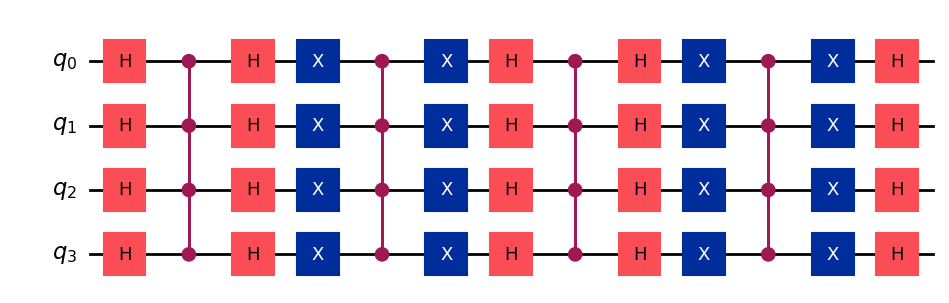

In [2]:
def oracle(qc, qubits):
    mcz = ZGate().control(num_ctrl_qubits=len(qubits)-1, ctrl_state='1'*(len(qubits)-1))
    qc.append(mcz, qubits)
    return qc

def diffuser(qc, qubits):
    qc.h(qubits)
    qc.x(qubits)
    mcz = ZGate().control(num_ctrl_qubits=len(qubits)-1, ctrl_state='1'*(len(qubits)-1))
    qc.append(mcz, qubits)
    qc.x(qubits)
    qc.h(qubits)
    return qc

def get_grover_circuit(n_qubits, n_repeats=2):
    qc = qiskit.QuantumCircuit(n_qubits)
    qubits = qc.qubits
    for q in qubits:
        qc.h(q)
    for _ in range(n_repeats):
        qc = oracle(qc, qubits)
        qc = diffuser(qc, qubits)
    return qc

n_qubits = 4
grover_circuit = get_grover_circuit(n_qubits)
grover_circuit.draw(output='mpl')

### Run Grover's algorithm using cuTensorNet Network State APIs
Now we create the network state for our Grover circuit.

In [3]:
# select tensor network contraction as the simulation method
config = TNConfig(num_hyper_samples=32)

# create a NetworkState object
state = NetworkState.from_circuit(grover_circuit, dtype='complex128', config=config, backend='cupy')

In [4]:
# compute the state vector
sv = state.compute_state_vector()
print(f"state vector type: {type(sv)}, \nstate vector: \n{sv}")

state vector type: <class 'cupy.ndarray'>, 
state vector: 
[[[[0.078125+6.81277837e-16j 0.078125+8.02590761e-16j]
   [0.078125+7.33116819e-16j 0.078125+5.71013751e-16j]]

  [[0.078125+7.11052314e-16j 0.078125+7.84815079e-16j]
   [0.078125+6.64090031e-16j 0.078125+5.28690888e-16j]]]


 [[[0.078125+6.49993769e-16j 0.078125+7.62742886e-16j]
   [0.078125+6.46643952e-16j 0.078125+4.94284648e-16j]]

  [[0.078125+5.09318159e-16j 0.078125+5.81124944e-16j]
   [0.078125+9.05076497e-16j 0.953125+6.23085135e-15j]]]]


In [5]:
# compute the bitstring amplitude
bitstring = '1' * n_qubits
amplitude = state.compute_amplitude(bitstring)
print(f"amplitude for {bitstring}: {amplitude}")

amplitude for 1111: (0.9531249999999978+6.13389955333702e-15j)


In [6]:
# compute samples from the state object
nshots = 1024
samples = state.compute_sampling(nshots)
print("Sampling results:")
print(samples)

Sampling results:
{'0000': 3, '0001': 6, '0010': 6, '0011': 9, '0100': 7, '0101': 4, '0110': 9, '0111': 7, '1000': 5, '1001': 5, '1010': 7, '1011': 5, '1100': 6, '1101': 4, '1110': 8, '1111': 933}


In [7]:
probabilities_ns = {}
for key, val in samples.items():
    probabilities_ns[key] = round(val / 1024., 3)
print("Probability results:")
print(probabilities_ns)

Probability results:
{'0000': 0.003, '0001': 0.006, '0010': 0.006, '0011': 0.009, '0100': 0.007, '0101': 0.004, '0110': 0.009, '0111': 0.007, '1000': 0.005, '1001': 0.005, '1010': 0.007, '1011': 0.005, '1100': 0.006, '1101': 0.004, '1110': 0.008, '1111': 0.911}


Then we plot the probabilities computed from cuTensorNEt that shows the item that we are looking for is $|1111\rangle$ with high probability. 

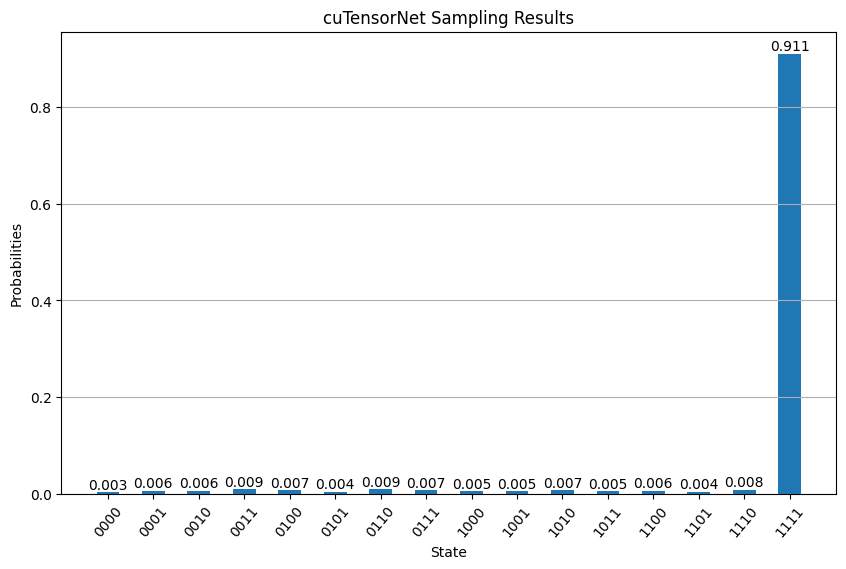

In [8]:
states = list(probabilities_ns.keys())
values = list(probabilities_ns.values())
# plot the result; note the keys are already sorted by numpy.unique() 
plt.figure(figsize=(10, 6)) 
plt.bar(range(len(states)), values, tick_label=states, width=0.5)
for i in range(len(states)):
    plt.text(i, values[i], str(values[i]), ha='center', va='bottom', fontsize=10, color='black')

plt.title('cuTensorNet Sampling Results')
plt.xlabel('State')
plt.ylabel('Probabilities')
plt.xticks(rotation=50)
plt.grid(axis='y')
plt.show()

**Note:** To compute the result using cuTensorNet, we don't need to decompose the grover circuit to smaller gates as cuTensorNet supports multi-controlled gates using MPO representation.

In [9]:
# release resources
state.free()

### Run Grover's algorithm using Qiskit
We run the circuit on state_vector and qasm simulators from `Qiskit` to compute state vectors and counts, respectively.

**Note:** To run the Grover circuit using Aer, we need to decompose the circuit to break down multi-controlled gates into elementary quantum gates.

In [10]:
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit_aer import Aer

sv_sim = Aer.get_backend('statevector_simulator')
decomposed_qc = grover_circuit.decompose()
result = sv_sim.run(decomposed_qc).result()

statevec = result.get_statevector()
print(f"state vector: \n{statevec}")

probabilities = result.get_counts()
print(f"Probabilities: \n{probabilities}")

state vector: 
Statevector([0.078125+3.91096761e-16j, 0.078125+3.36338762e-16j,
             0.078125+3.81168738e-16j, 0.078125+1.26178593e-16j,
             0.078125+2.94673344e-16j, 0.078125+3.01063348e-16j,
             0.078125+2.65349056e-16j, 0.078125+5.19088217e-16j,
             0.078125+5.61262841e-16j, 0.078125+4.19759283e-16j,
             0.078125+5.71190865e-16j, 0.078125+3.55153272e-16j,
             0.078125+4.02546234e-16j, 0.078125+3.56903918e-16j,
             0.078125+3.53365899e-16j, 0.953125+2.88732811e-15j],
            dims=(2, 2, 2, 2))
Probabilities: 
{'0000': 0.006103515625, '0001': 0.006103515625, '0010': 0.006103515625, '0011': 0.006103515625, '0100': 0.006103515625, '0101': 0.006103515625, '0110': 0.006103515625, '0111': 0.006103515625, '1000': 0.006103515625, '1001': 0.006103515625, '1010': 0.006103515625, '1011': 0.006103515625, '1100': 0.006103515625, '1101': 0.006103515625, '1110': 0.006103515625, '1111': 0.908447265624998}


Then we draw a histogram for the probabilities that shows the item that we are looking for is $|1111\rangle$ with high probability. 

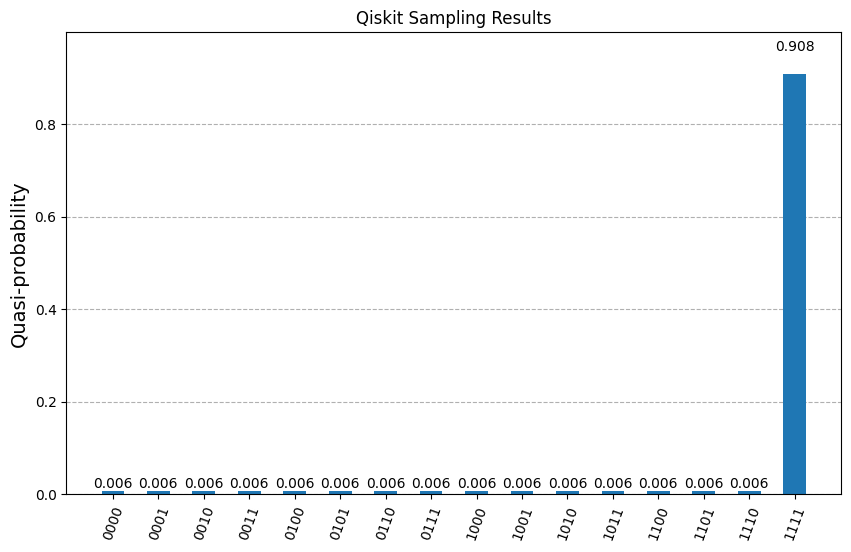

In [11]:
options = {
    'figsize': (10, 6),
    'bar_labels': True,
    'title': 'Qiskit Sampling Results'
}
plot_histogram(probabilities, **options)